In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from tqdm import tqdm_notebook as tqdm
from tcn import TCN
import time
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from keras.preprocessing import sequence
from keras.models import Sequential , load_model , Model
from keras.layers import Dense, Dropout , LSTM , Bidirectional ,GRU ,Flatten,Add,BatchNormalization
from keras_layer_normalization import LayerNormalization
from keras.initializers import  glorot_normal, RandomUniform
from keras import optimizers,Input
from keras_self_attention import SeqSelfAttention
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Using TensorFlow backend.


In [2]:
df = pd.read_csv("station_bike _Soho.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.set_index("timestamp")
#df.head()

df["hour"] = df.index.hour
df["day_of_month"] = df.index.day
df["day_of_week"]  = df.index.dayofweek
df["month"] = df.index.month

training_data_len = math.ceil(len(df) * 0.9) # taking 90% of data to train and 10% of data to test
testing_data_len = len(df) - training_data_len

time_steps = 24
train, test = df.iloc[0:training_data_len], df.iloc[(training_data_len-time_steps):len(df)]
print(df.shape, train.shape, test.shape)
train_trans = train[['t1','t2', 'hum', 'wind_speed']].to_numpy()
test_trans = test[['t1','t2', 'hum', 'wind_speed']].to_numpy()

scaler = RobustScaler() # Handles outliers
#scaler = MinMaxScaler(feature_range=(0, 1)) # scale to (0,1)
train.loc[:, ['t1','t2','hum', 'wind_speed']]=scaler.fit_transform(train_trans)
test.loc[:, ['t1','t2', 'hum', 'wind_speed']]=scaler.fit_transform(test_trans)

train['cnt'] = scaler.fit_transform(train[['cnt']])
test['cnt'] = scaler.fit_transform(test[['cnt']])

#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in tqdm(range(len(train) - time_steps)):
    x_train.append(train.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    y_train.append(train.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

#Create the x_test and y_test data sets
x_test = []
y_test = df.loc[:,'cnt'].iloc[training_data_len:len(df)]

for i in tqdm(range(len(test) - time_steps)):
    x_test.append(test.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    # y_test.append(test.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_test and y_test to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

# All 12 columns of the data
print('Train size:')
print(x_train.shape, y_train.shape)
print('Test size:')
print(x_test.shape, y_test.shape)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

(160, 13) (144, 13) (40, 13)


  0%|          | 0/120 [00:00<?, ?it/s]

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/16 [00:00<?, ?it/s]

Train size:
(120, 24, 12) (120,)
Test size:
(16, 24, 12) (16,)


In [7]:
from keras.layers import Concatenate
init = glorot_normal(seed=None) # 給 GRU
init_d = RandomUniform(minval=-0.05, maxval=0.05) # 給 Dense layer

def Encoder(layer):
    shortcut = layer
    layer = SeqSelfAttention(
                     attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                     kernel_regularizer=tf.keras.regularizers.l2(0.01),
                     bias_regularizer=tf.keras.regularizers.l2(0.01),
                     attention_regularizer_weight=0.0001)(layer)
    layer = Add()([layer,shortcut])
    layer = LayerNormalization()(layer)
    layer = Flatten()(layer)
    
    shortcut2 = layer
    layer = Dense(12,kernel_initializer=init_d)(layer)
    layer = Dropout(0.15)(layer)
    layer = Concatenate()([layer,shortcut2])
    output = Dense(1,kernel_initializer=init_d)(layer)
    return output

def Decoder(layer):
    shortcut = layer
    layer = SeqSelfAttention(
                     attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                     kernel_regularizer=tf.keras.regularizers.l2(0.01),
                     bias_regularizer=tf.keras.regularizers.l2(0.01),
                     attention_regularizer_weight=0.0001)(layer)
    layer = Add()([layer,shortcut])
    layer = LayerNormalization()(layer)
    layer = SeqSelfAttention(
                     attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                     kernel_regularizer=tf.keras.regularizers.l2(0.01),
                     bias_regularizer=tf.keras.regularizers.l2(0.01),
                     attention_regularizer_weight=0.0001)(layer)
    layer = LayerNormalization()(layer)
    
    layer = Flatten()(layer)
    shortcut2 = layer
    layer = Dense(10,kernel_initializer=init_d)(layer)
    #layer = Dropout(0.2)(layer)
    layer = Concatenate()([layer,shortcut2])
    output = Dense(1,kernel_initializer=init_d)(layer)
    return output

def Bi_GRU(layer,unit):
    output = Bidirectional(GRU(unit, dropout=0.1, recurrent_dropout=0.1, return_sequences=True,
                            kernel_initializer=init))(layer)
    return output

#start = Input(shape = (x_train.shape[1],x_train.shape[2]))
start = Input(shape = (x_train.shape[1:]))
start2 = Input(shape = (x_train.shape[1:]))
x = Bi_GRU(start,12)
x = Encoder(x)

# y = Bi_GRU(start2,8)
# y = Decoder(y)

#Merge = Add()([x,x])
Last = Dense(1)(x)
model = Model([start,start2] , Last)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 24, 12)       0                                            
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 24, 24)       1800        input_5[0][0]                    
__________________________________________________________________________________________________
seq_self_attention_3 (SeqSelfAt (None, 24, 24)       577         bidirectional_3[0][0]            
__________________________________________________________________________________________________
add_3 (Add)                     (None, 24, 24)       0           seq_self_attention_3[0][0]       
                                                                 bidirectional_3[0][0]      

Train...
Train on 108 samples, validate on 12 samples
Epoch 1/500
108/108 [==============================] - 2s 19ms/step - loss: 0.7637 - val_loss: 0.6613
Epoch 2/500
108/108 [==============================] - 1s 7ms/step - loss: 0.6699 - val_loss: 0.5960
Epoch 3/500
108/108 [==============================] - 1s 7ms/step - loss: 0.6143 - val_loss: 0.5504
Epoch 4/500
108/108 [==============================] - 1s 7ms/step - loss: 0.5430 - val_loss: 0.6947
Epoch 5/500
108/108 [==============================] - 1s 8ms/step - loss: 0.5333 - val_loss: 0.5294
Epoch 6/500
108/108 [==============================] - 1s 7ms/step - loss: 0.5252 - val_loss: 0.4377
Epoch 7/500
108/108 [==============================] - 1s 7ms/step - loss: 0.5338 - val_loss: 0.4992
Epoch 8/500
108/108 [==============================] - 1s 7ms/step - loss: 0.4817 - val_loss: 0.4998
Epoch 9/500
108/108 [==============================] - 1s 7ms/step - loss: 0.4492 - val_loss: 0.3942
Epoch 10/500
108/108 [==============

Epoch 81/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0748 - val_loss: 0.2804
Epoch 82/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0577 - val_loss: 0.1848
Epoch 83/500
108/108 [==============================] - 1s 6ms/step - loss: 0.0778 - val_loss: 0.1558
Epoch 84/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0718 - val_loss: 0.2228
Epoch 85/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0694 - val_loss: 0.1480
Epoch 86/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0737 - val_loss: 0.1690
Epoch 87/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0844 - val_loss: 0.2636
Epoch 88/500
108/108 [==============================] - ETA: 0s - loss: 0.049 - 1s 7ms/step - loss: 0.0511 - val_loss: 0.1760
Epoch 89/500
108/108 [==============================] - 1s 6ms/step - loss: 0.0825 - val_loss: 0.2321
Epoch 90/500
108/108 [==============================] - 1s

108/108 [==============================] - 1s 7ms/step - loss: 0.0861 - val_loss: 0.1924
Epoch 161/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0574 - val_loss: 0.3091
Epoch 162/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0433 - val_loss: 0.3128
Epoch 163/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0682 - val_loss: 0.2330
Epoch 164/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0402 - val_loss: 0.2436
Epoch 165/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0589 - val_loss: 0.2868
Epoch 166/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0551 - val_loss: 0.2445
Epoch 167/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0442 - val_loss: 0.2803
Epoch 168/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0430 - val_loss: 0.2218
Epoch 169/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0650 - v

108/108 [==============================] - 1s 7ms/step - loss: 0.0550 - val_loss: 0.2507
Epoch 240/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0538 - val_loss: 0.2204
Epoch 241/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0471 - val_loss: 0.3239
Epoch 242/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0394 - val_loss: 0.2414
Epoch 243/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0397 - val_loss: 0.2443
Epoch 244/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0411 - val_loss: 0.2053
Epoch 245/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0436 - val_loss: 0.2190
Epoch 246/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0419 - val_loss: 0.2112
Epoch 247/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0381 - val_loss: 0.2744
Epoch 248/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0284 - v

108/108 [==============================] - 1s 7ms/step - loss: 0.0389 - val_loss: 0.2144
Epoch 319/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0307 - val_loss: 0.1354
Epoch 320/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0263 - val_loss: 0.2055
Epoch 321/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0294 - val_loss: 0.2273
Epoch 322/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0251 - val_loss: 0.1946
Epoch 323/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0397 - val_loss: 0.1741
Epoch 324/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0368 - val_loss: 0.1824
Epoch 325/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0485 - val_loss: 0.2599
Epoch 326/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0442 - val_loss: 0.1983
Epoch 327/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0281 - v

108/108 [==============================] - 1s 7ms/step - loss: 0.0207 - val_loss: 0.2554
Epoch 398/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0272 - val_loss: 0.1759
Epoch 399/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0243 - val_loss: 0.1717
Epoch 400/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0222 - val_loss: 0.1934
Epoch 401/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0247 - val_loss: 0.1949
Epoch 402/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0392 - val_loss: 0.1569
Epoch 403/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0250 - val_loss: 0.2363
Epoch 404/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0234 - val_loss: 0.1795
Epoch 405/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0361 - val_loss: 0.2663
Epoch 406/500
108/108 [==============================] - 1s 7ms/step - loss: 0.0222 - v

108/108 [==============================] - 1s 5ms/step - loss: 0.0183 - val_loss: 0.1852
Epoch 477/500
108/108 [==============================] - 1s 5ms/step - loss: 0.0274 - val_loss: 0.1613
Epoch 478/500
108/108 [==============================] - 1s 5ms/step - loss: 0.0245 - val_loss: 0.1462
Epoch 479/500
108/108 [==============================] - 1s 5ms/step - loss: 0.0208 - val_loss: 0.1566
Epoch 480/500
108/108 [==============================] - 1s 5ms/step - loss: 0.0252 - val_loss: 0.1769
Epoch 481/500
108/108 [==============================] - 1s 5ms/step - loss: 0.0272 - val_loss: 0.1647
Epoch 482/500
108/108 [==============================] - 1s 5ms/step - loss: 0.0239 - val_loss: 0.1423
Epoch 483/500
108/108 [==============================] - 1s 5ms/step - loss: 0.0220 - val_loss: 0.1516
Epoch 484/500
108/108 [==============================] - 1s 5ms/step - loss: 0.0176 - val_loss: 0.1982
Epoch 485/500
108/108 [==============================] - 1s 5ms/step - loss: 0.0210 - v

Text(0, 0.5, 'mse score')

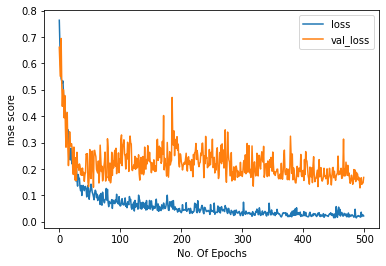

In [8]:
opt = optimizers.Adam(lr=0.001,decay = 0.0001)
print('Train...')
# model.compile(optimizer = opt , loss="mse")
model.compile(optimizer = "adam" , loss="mse")
history = model.fit([x_train,x_train], y_train, epochs = 500, batch_size=8, validation_split=0.1, shuffle=True)
# history = model.fit(x_train, y_train, epochs = 500, batch_size=6, validation_split=0.1, shuffle=True)
model.summary()
#Save Model
model.save('GRU_Single_Attention_model_Soho.h5')  # creates a HDF5 file 
del model

custom_ob = {'LayerNormalization': LayerNormalization , 'SeqSelfAttention':SeqSelfAttention}
model = load_model('GRU_Single_Attention_model_Soho.h5', custom_objects=custom_ob)
t1 = time.time()
# y_pred = model.predict([x_test,x_test])
y_pred2 = model.predict(x_test)
y_pred = model.predict(x_train)
t2 = time.time()
print('Predict time: ',t2-t1)
y_pred = scaler.inverse_transform(y_pred)#Undo scaling
rmse_lstm2 = np.sqrt(mean_squared_error(y_test, y_pred2))
rmse_lstm = np.sqrt(mean_squared_error(y_train, y_pred))
print('RMSE: ',rmse_lstm)
print('RMSE2: ',rmse_lstm2)
mae = mean_absolute_error(y_test, y_pred2)
mae = mean_absolute_error(y_train, y_pred)
print('MAE: ',mae)
print('MAE2: ',mae)
# r22 =  r2_score(y_test, y_pred2)
# r2 =  r2_score(y_train, y_pred)
# print('R-square: ',r2)
# print('R-square2: ',r22)

# n = len(y_test)
# p = 12
# Adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
# Adj_r22 = 1-(1-r22)*(n-1)/(n-p-1)
# print('Adj R-square: ',Adj_r2)
# print('Adj R-square2: ',Adj_r22)

plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

Train on 108 samples, validate on 12 samples
Epoch 1/200
108/108 [==============================] - 2s 22ms/step - loss: 1.3543 - val_loss: 1.4991
Epoch 2/200
108/108 [==============================] - 1s 5ms/step - loss: 1.3140 - val_loss: 1.4301
Epoch 3/200
108/108 [==============================] - 1s 5ms/step - loss: 1.2927 - val_loss: 1.3809
Epoch 4/200
108/108 [==============================] - 1s 5ms/step - loss: 1.2374 - val_loss: 1.3246
Epoch 5/200
108/108 [==============================] - 1s 5ms/step - loss: 1.2098 - val_loss: 1.2778
Epoch 6/200
108/108 [==============================] - 1s 5ms/step - loss: 1.1638 - val_loss: 1.2292
Epoch 7/200
108/108 [==============================] - 1s 5ms/step - loss: 1.1217 - val_loss: 1.1859
Epoch 8/200
108/108 [==============================] - 1s 5ms/step - loss: 1.0923 - val_loss: 1.1507
Epoch 9/200
108/108 [==============================] - 1s 5ms/step - loss: 1.0565 - val_loss: 1.1106
Epoch 10/200
108/108 [=======================

Epoch 81/200
108/108 [==============================] - 0s 5ms/step - loss: 0.3197 - val_loss: 0.4173
Epoch 82/200
108/108 [==============================] - 1s 5ms/step - loss: 0.3233 - val_loss: 0.4086
Epoch 83/200
108/108 [==============================] - 0s 5ms/step - loss: 0.3109 - val_loss: 0.4217
Epoch 84/200
108/108 [==============================] - 0s 4ms/step - loss: 0.2996 - val_loss: 0.4218
Epoch 85/200
108/108 [==============================] - 1s 5ms/step - loss: 0.3123 - val_loss: 0.4462
Epoch 86/200
108/108 [==============================] - 0s 5ms/step - loss: 0.3183 - val_loss: 0.4257
Epoch 87/200
108/108 [==============================] - 0s 4ms/step - loss: 0.2883 - val_loss: 0.4110
Epoch 88/200
108/108 [==============================] - 1s 5ms/step - loss: 0.3035 - val_loss: 0.4051
Epoch 89/200
108/108 [==============================] - 1s 5ms/step - loss: 0.3103 - val_loss: 0.4103
Epoch 90/200
108/108 [==============================] - 1s 5ms/step - loss: 0.2768

108/108 [==============================] - 0s 3ms/step - loss: 0.1890 - val_loss: 0.3580
Epoch 161/200
108/108 [==============================] - 0s 3ms/step - loss: 0.2099 - val_loss: 0.3765
Epoch 162/200
108/108 [==============================] - 0s 3ms/step - loss: 0.1817 - val_loss: 0.3787
Epoch 163/200
108/108 [==============================] - 0s 3ms/step - loss: 0.1821 - val_loss: 0.4049
Epoch 164/200
108/108 [==============================] - 0s 3ms/step - loss: 0.1904 - val_loss: 0.3700
Epoch 165/200
108/108 [==============================] - 0s 3ms/step - loss: 0.1890 - val_loss: 0.4445
Epoch 166/200
108/108 [==============================] - 0s 3ms/step - loss: 0.1925 - val_loss: 0.3572
Epoch 167/200
108/108 [==============================] - 0s 3ms/step - loss: 0.1802 - val_loss: 0.3945
Epoch 168/200
108/108 [==============================] - 0s 3ms/step - loss: 0.1714 - val_loss: 0.4874
Epoch 169/200
108/108 [==============================] - 0s 3ms/step - loss: 0.1879 - v

Text(0, 0.5, 'mse score')

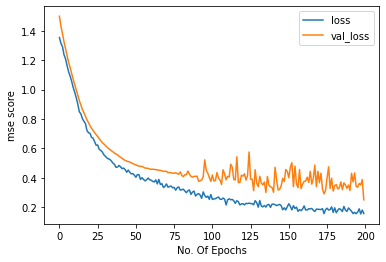

In [13]:
from keras import regularizers
init = glorot_normal(seed=None) # 給 LSTM
init_d = RandomUniform(minval=-0.05, maxval=0.05) # 給 Dense layer
nadam = optimizers.Nadam(lr=0.0015,clipvalue=0.5)

model = Sequential()
model.add(Bidirectional(GRU(6, kernel_initializer=init ,return_sequences = True,kernel_regularizer=regularizers.l2(0.01)
                             ,recurrent_regularizer = regularizers.l2(0.01) ,input_shape=(x_train.shape[1],x_train.shape[2]))))
model.add(LayerNormalization())
model.add(Bidirectional(GRU(6,kernel_initializer=init,kernel_regularizer=regularizers.l2(0.01),recurrent_regularizer = regularizers.l2(0.01))))
model.add(Dropout(0.15))
model.add(Dense(units=1, kernel_initializer=init_d))
model.compile(optimizer = nadam , loss="mse")
history = model.fit(x_train, y_train, epochs=200, batch_size=24, validation_split=0.1, shuffle=True)
#model summary
model.summary()
#Save Model
model.save('GRU_model_soho.h5')  # creates a HDF5 file 
print('Model Saved')
del model  # deletes the existing model

custom_ob = {'LayerNormalization': LayerNormalization , 'SeqSelfAttention':SeqSelfAttention}
model = load_model('GRU_model_soho.h5', custom_objects=custom_ob)
t1 = time.time()
# y_pred = model.predict([x_test,x_test])
y_pred2 = model.predict(x_test)
y_pred = model.predict(x_train)
t2 = time.time()
print('Predict time: ',t2-t1)
y_pred = scaler.inverse_transform(y_pred)#Undo scaling
rmse_lstm2 = np.sqrt(mean_squared_error(y_test, y_pred2))
rmse_lstm = np.sqrt(mean_squared_error(y_train, y_pred))
print('RMSE: ',rmse_lstm)
print('RMSE2: ',rmse_lstm2)
mae = mean_absolute_error(y_test, y_pred2)
mae = mean_absolute_error(y_train, y_pred)
print('MAE: ',mae)
print('MAE2: ',mae)
# r22 =  r2_score(y_test, y_pred2)
# r2 =  r2_score(y_train, y_pred)
# print('R-square: ',r2)
# print('R-square2: ',r22)

# n = len(y_test)
# p = 12
# Adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
# Adj_r22 = 1-(1-r22)*(n-1)/(n-p-1)
# print('Adj R-square: ',Adj_r2)
# print('Adj R-square2: ',Adj_r22)

plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")